In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import erf
from mpmath import mp
from scipy import integrate
from scipy.integrate import simpson
from scipy.special import erf
from dataclasses import dataclass, field
from sklearn.metrics import mean_squared_error

mp.dps = 550

# Customize matplotlib
matplotlib.rcParams.update(
	{
		'text.usetex': False,
		'font.family': 'stixgeneral',
		'mathtext.fontset': 'stix',
		'font.size': 22,
		'ytick.color' : 'black',
		"xtick.color" : 'black',
		'axes.labelcolor' : 'black',
		'axes.edgecolor' : 'black'
	}
)

In [16]:
@dataclass
class Parameters:
    Vth:float
    Vr: float
    KE: int
    KI: int
    wE: float
    wI: float
    tauE: float
    tauN: float
    tauI: float
    tauL: float
    tauR: float
    EE: float
    EI: float
    EL: float
    alpha: float
    nu: float

    muE: float = field(init=False)
    muN: float = field(init=False)
    muI: float = field(init=False)
    sigmaE: float = field(init=False)
    sigmaN: float = field(init=False)
    sigmaI: float = field(init=False)
    mu: float = field(init=False)
    tau: float = field(init=False)
    hE: float = field(init=False)
    hN: float = field(init=False)
    hI: float = field(init=False)

    def __post_init__(self):
        self.recalculate()

    def recalculate(self):
        self.muE = self.wE*self.KE*self.nu*self.tauE
        self.muN = self.wE*self.KE*self.nu*self.tauN
        self.muI = self.wI*self.KI*self.nu*self.tauI
        self.sigmaE = self.wE*np.sqrt(self.KE*self.nu*self.tauE)
        self.sigmaN = self.wE*np.sqrt(self.KE*self.nu*self.tauN)
        self.sigmaI = self.wI*np.sqrt(self.KI*self.nu*self.tauI)
        self.tau = self.tauL/(1 + (1 - self.alpha)*self.muE + self.alpha*self.muN + self.muI)
        self.mu = self.tau*(self.EL + ((1 - self.alpha)*self.muE + self.alpha*self.muN)*self.EE + self.muI*self.EI)/self.tauL
        self.hE = (1 - self.alpha)*(self.tau/self.tauL)*self.sigmaE*(self.EE - self.mu)
        self.hN = self.alpha*(self.tau/self.tauL)*self.sigmaN*(self.EE - self.mu)
        self.hI = (self.tau/self.tauL)*self.sigmaI*(self.EI - self.mu)

    def set_tauE(self, tauE):
        self.tauE = tauE
        self.recalculate()

    def set_nu(self, nu):
        self.nu = nu
        self.recalculate()

    def calculate_sigma(self):
        return np.sqrt((self.tauE * self.hE**2)/(self.tau + self.tauE) + (self.tauN * self.hN**2)/(self.tau + self.tauN) + (self.tauI * self.hI**2)/(self.tau + self.tauI))

In [9]:
df_varV_iRate = pd.read_csv('var_V_interpolated.dat', index_col=0)
# df_varV_wE = pd.read_csv('var_V_ta_wE.dat', index_col=0)
# df_varV_wI = pd.read_csv('var_V_ta_wI.dat', index_col=0)

df_varV_iRate

,alpha,5,10,20
0,0.503368,7.847579,4.346607,2.530354
1,0.469712,8.270755,4.908172,2.804447
2,0.908144,4.124543,2.285954,1.166362
3,0.817434,4.439828,2.665912,1.323777
4,0.994230,3.551746,2.010332,1.037262
...,...,...,...,...
195,0.727102,5.063041,3.182323,1.687877
196,0.160989,16.524262,11.217480,6.437192
197,0.060399,16.447339,12.240234,8.764906
198,0.800191,4.788508,2.866909,1.449848


In [4]:
vec_alpha = np.linspace(0, 1, 100)
vec_iRate = np.array([0.005, 0.01, 0.02])
# vec_wE = np.array([0.1, 1.0, 10])
# vec_wI = np.array([0.1, 1.0, 10])
dic_varV_iRate = {vec_iRate[0]:np.zeros_like(vec_alpha), vec_iRate[1]:np.zeros_like(vec_alpha), vec_iRate[2]:np.zeros_like(vec_alpha)}
# dic_varV_wE = {vec_wE[0]:np.zeros_like(vec_tauE), vec_wE[1]:np.zeros_like(vec_tauE), vec_wE[2]:np.zeros_like(vec_tauE)}
# dic_varV_wI = {vec_wI[0]:np.zeros_like(vec_tauE), vec_wI[1]:np.zeros_like(vec_tauE), vec_wI[2]:np.zeros_like(vec_tauE)}

In [17]:
for iRate in vec_iRate:
	for i, alpha in enumerate(vec_alpha):
		parameters = Parameters(Vth=-50, Vr=-60, KE=400, KI=100, wE=0.1, wI=0.4, tauE=5, tauN=100, tauI=10, tauL=20, tauR=2, EE=0, EI=-80, EL=-60, alpha=alpha, nu=iRate)

		dic_varV_iRate[iRate][i] = parameters.calculate_sigma()

# for wE in vec_wE:
# 	for i, tauE in enumerate(vec_tauE):
# 		parameters = Parameters(Vth=-50, Vr=-60, KE=400, KI=100, wE=wE, wI=0.8, tauE=tauE, tauI=10, tauL=20, tauR=2, EE=0, EI=-80, EL=-60, nu=0.005)

# 		dic_varV_wE[wE][i] = parameters.calculate_sigma()

# for wI in vec_wI:
# 	for i, tauE in enumerate(vec_tauE):
# 		parameters = Parameters(Vth=-50, Vr=-60, KE=400, KI=100, wE=0.5, wI=wI, tauE=tauE, tauI=10, tauL=20, tauR=2, EE=0, EI=-80, EL=-60, nu=0.005)

# 		dic_varV_wI[wI][i] = parameters.calculate_sigma()

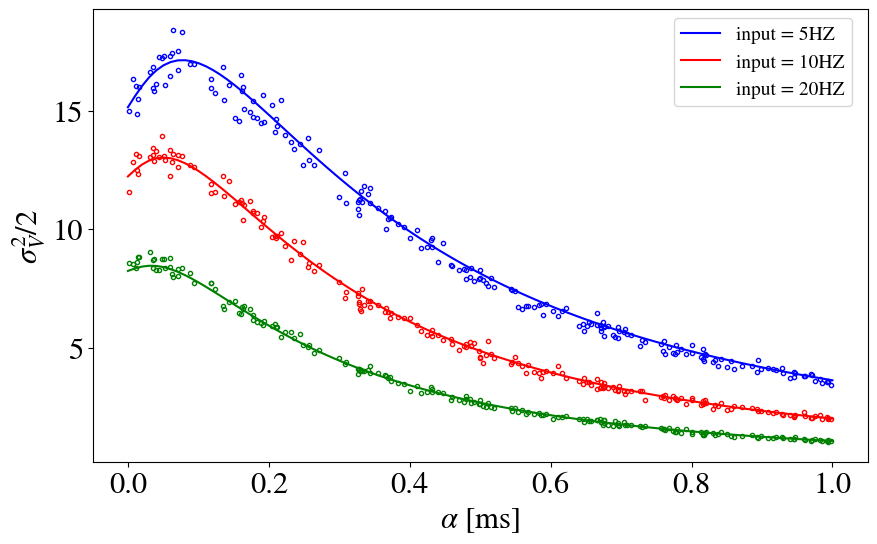

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(10,6), dpi=100)

axs.set_xlabel(r'$\alpha$ [ms]')
axs.set_ylabel(r'$\sigma_V^2/2$')

# axs.set_ylim(-1, 50)
axs.plot(df_varV_iRate['alpha'], df_varV_iRate['5'], 'b.', markerfacecolor='none')
axs.plot(df_varV_iRate['alpha'], df_varV_iRate['10'], 'r.', markerfacecolor='none')
axs.plot(df_varV_iRate['alpha'], df_varV_iRate['20'], 'g.', markerfacecolor='none')
axs.plot(vec_alpha, dic_varV_iRate[vec_iRate[0]]**2/2, 'b-', label='input = 5HZ')
axs.plot(vec_alpha, dic_varV_iRate[vec_iRate[1]]**2/2, 'r-', label='input = 10HZ')
axs.plot(vec_alpha, dic_varV_iRate[vec_iRate[2]]**2/2, 'g-', label='input = 20HZ')
axs.legend(bbox_to_anchor=(0.98, 0.98), loc=1, borderaxespad=0., prop={'size': 14})

# axs[1].set_xlabel(r'$\tau_E$ [ms]')

# axs[1].set_ylim(-1, 50)
# axs[1].plot(df_varV_wE['tauA'], df_varV_wE['0.1'], 'b.', markerfacecolor='none')
# axs[1].plot(df_varV_wE['tauA'], df_varV_wE['1'], 'r.', markerfacecolor='none')
# axs[1].plot(df_varV_wE['tauA'], df_varV_wE['10'], 'g.', markerfacecolor='none')
# axs[1].plot(vec_tauE, dic_varV_wE[vec_wE[0]]**2/2, 'b-', label=r'$w_E = 0.1$')
# axs[1].plot(vec_tauE, dic_varV_wE[vec_wE[1]]**2/2, 'r-', label=r'$w_E = 1.0$')
# axs[1].plot(vec_tauE, dic_varV_wE[vec_wE[2]]**2/2, 'g-', label=r'$w_E = 10.0$')
# axs[1].legend(bbox_to_anchor=(0.98, 0.98), loc=1, borderaxespad=0., prop={'size': 14})

# axs[2].set_xlabel(r'$\tau_E$ [ms]')

# axs[2].set_ylim(-1, 50)
# axs[2].plot(df_varV_wI['tauA'], df_varV_wI['0.1'], 'b.', markerfacecolor='none')
# axs[2].plot(df_varV_wI['tauA'], df_varV_wI['1'], 'r.', markerfacecolor='none')
# axs[2].plot(df_varV_wI['tauA'], df_varV_wI['10'], 'g.', markerfacecolor='none')
# axs[2].plot(vec_tauE, dic_varV_wI[vec_wI[0]]**2/2, 'b-', label=r'$w_I = 0.1$')
# axs[2].plot(vec_tauE, dic_varV_wI[vec_wI[1]]**2/2, 'r-', label=r'$w_I = 1.0$')
# axs[2].plot(vec_tauE, dic_varV_wI[vec_wI[2]]**2/2, 'g-', label=r'$w_I = 10.0$')
# axs[2].legend(bbox_to_anchor=(0.98, 0.98), loc=1, borderaxespad=0., prop={'size': 14})

In [8]:
df_nu_iRate = pd.read_csv('firing_rate_iRate.dat', index_col=0)
df_nu_iRate_analytic = pd.read_csv('analytic_fRate_iRate.dat')

df_nu_wE = pd.read_csv('firing_rate_wE.dat', index_col=0)
df_nu_wE_analytic = pd.read_csv('analytic_fRate_wE.dat')

df_nu_wI = pd.read_csv('firing_rate_wI.dat', index_col=0)
df_nu_wI_analytic = pd.read_csv('analytic_fRate_wI.dat')

df_nu_iRate_analytic

,tauA,5,10,20
0,0.10000,4.191681e-84,9.926694e-287,0.000000e+00
1,0.60201,4.989175e-37,6.517563e-74,1.774996e-139
2,1.10402,3.835981e-19,2.942282e-30,1.217239e-48
3,1.60603,2.971715e-11,1.262802e-15,2.006811e-23
4,2.10804,2.830676e-07,3.389414e-09,4.467307e-13
...,...,...,...,...
195,97.99196,4.553820e-01,4.766885e-01,4.880758e-01
196,98.49397,4.555999e-01,4.768075e-01,4.881381e-01
197,98.99598,4.558157e-01,4.769253e-01,4.881998e-01
198,99.49799,4.560295e-01,4.770419e-01,4.882608e-01


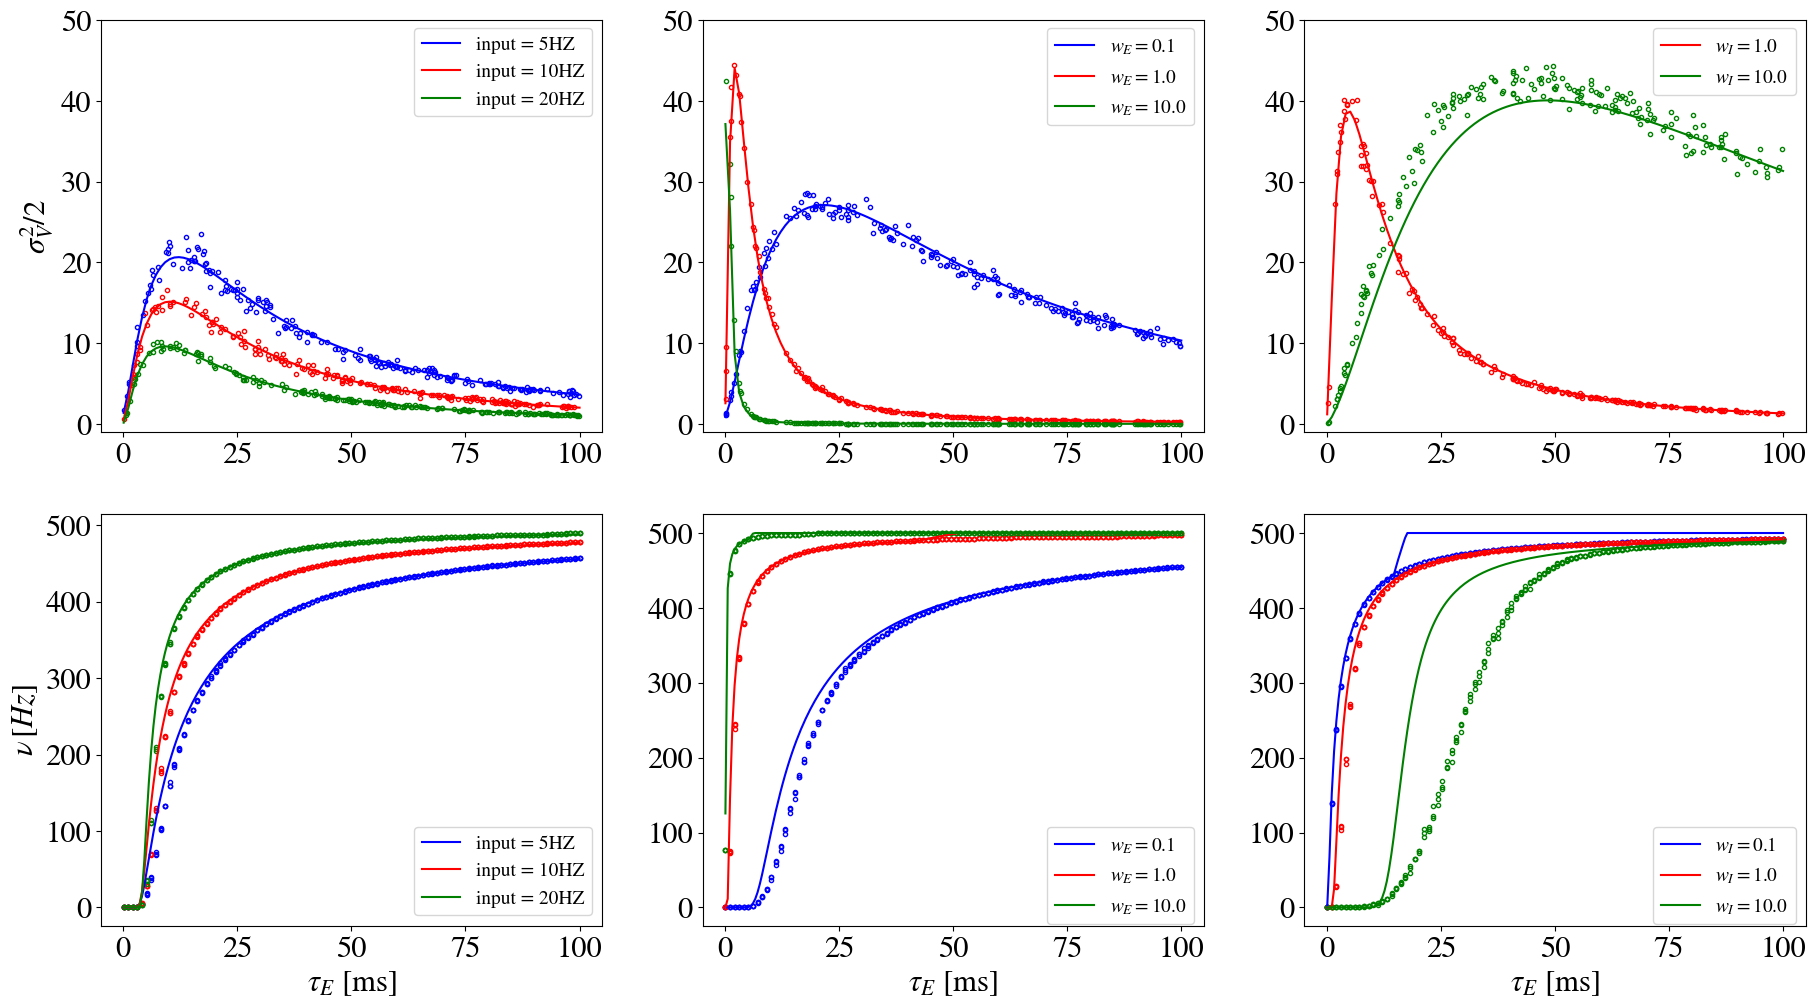

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(22,12), dpi=100)

axs[0][0].set_ylabel(r'$\sigma_V^2/2$')

axs[0][0].set_ylim(-1, 50)
axs[0][0].plot(df_varV_iRate['tau (nu=5)'][:-100], df_varV_iRate['5'][:-100], 'b.', markerfacecolor='none')
axs[0][0].plot(df_varV_iRate['tau (nu=10)'][:-100], df_varV_iRate['10'][:-100], 'r.', markerfacecolor='none')
axs[0][0].plot(df_varV_iRate['tau (nu=20)'][:-100], df_varV_iRate['20'][:-100], 'g.', markerfacecolor='none')
axs[0][0].plot(vec_tauE, dic_varV_iRate[vec_iRate[0]]**2/2, 'b-', label='input = 5HZ')
axs[0][0].plot(vec_tauE, dic_varV_iRate[vec_iRate[1]]**2/2, 'r-', label='input = 10HZ')
axs[0][0].plot(vec_tauE, dic_varV_iRate[vec_iRate[2]]**2/2, 'g-', label='input = 20HZ')
axs[0][0].legend(bbox_to_anchor=(0.98, 0.98), loc=1, borderaxespad=0., prop={'size': 14})


axs[0][1].set_ylim(-1, 50)
axs[0][1].plot(df_varV_wE['tauA'], df_varV_wE['0.1'], 'b.', markerfacecolor='none')
axs[0][1].plot(df_varV_wE['tauA'], df_varV_wE['1'], 'r.', markerfacecolor='none')
axs[0][1].plot(df_varV_wE['tauA'], df_varV_wE['10'], 'g.', markerfacecolor='none')
axs[0][1].plot(vec_tauE, dic_varV_wE[vec_wE[0]]**2/2, 'b-', label=r'$w_E = 0.1$')
axs[0][1].plot(vec_tauE, dic_varV_wE[vec_wE[1]]**2/2, 'r-', label=r'$w_E = 1.0$')
axs[0][1].plot(vec_tauE, dic_varV_wE[vec_wE[2]]**2/2, 'g-', label=r'$w_E = 10.0$')
axs[0][1].legend(bbox_to_anchor=(0.98, 0.98), loc=1, borderaxespad=0., prop={'size': 14})


axs[0][2].set_ylim(-1, 50)
# axs[0][2].plot(df_varV_wI['tauA'], df_varV_wI['0.1'], 'b.', markerfacecolor='none')
axs[0][2].plot(df_varV_wI['tauA'], df_varV_wI['1'], 'r.', markerfacecolor='none')
axs[0][2].plot(df_varV_wI['tauA'], df_varV_wI['10'], 'g.', markerfacecolor='none')
# axs[0][2].plot(vec_tauE, dic_varV_wI[vec_wI[0]]**2/2, 'b-', label=r'$w_I = 0.1$')
axs[0][2].plot(vec_tauE, dic_varV_wI[vec_wI[1]]**2/2, 'r-', label=r'$w_I = 1.0$')
axs[0][2].plot(vec_tauE, dic_varV_wI[vec_wI[2]]**2/2, 'g-', label=r'$w_I = 10.0$')
axs[0][2].legend(bbox_to_anchor=(0.98, 0.98), loc=1, borderaxespad=0., prop={'size': 14})


axs[1][0].set_xlabel(r'$\tau_E$ [ms]')
axs[1][0].set_ylabel(r'$\nu \, [Hz]$')

axs[1][0].plot(df_nu_iRate['tauA'], df_nu_iRate['5'], 'b.', markerfacecolor='none')
axs[1][0].plot(df_nu_iRate['tauA'], df_nu_iRate['10'], 'r.', markerfacecolor='none')
axs[1][0].plot(df_nu_iRate['tauA'], df_nu_iRate['20'], 'g.', markerfacecolor='none')
axs[1][0].plot(df_nu_iRate_analytic['tauA'], df_nu_iRate_analytic['5']*1000, 'b-', label='input = 5HZ')
axs[1][0].plot(df_nu_iRate_analytic['tauA'], df_nu_iRate_analytic['10']*1000, 'r-', label='input = 10HZ')
axs[1][0].plot(df_nu_iRate_analytic['tauA'], df_nu_iRate_analytic['20']*1000, 'g-', label='input = 20HZ')
axs[1][0].legend(bbox_to_anchor=(0.98, 0.24), loc=1, borderaxespad=0., prop={'size': 14})

axs[1][1].set_xlabel(r'$\tau_E$ [ms]')

axs[1][1].plot(df_nu_wE['tauA'], df_nu_wE['0.1'], 'b.', markerfacecolor='none')
axs[1][1].plot(df_nu_wE['tauA'], df_nu_wE['1'], 'r.', markerfacecolor='none')
axs[1][1].plot(df_nu_wE['tauA'], df_nu_wE['10'], 'g.', markerfacecolor='none')
axs[1][1].plot(df_nu_wE_analytic['tauA'], df_nu_wE_analytic['0.1']*1000, 'b-', label=r'$w_E = 0.1$')
axs[1][1].plot(df_nu_wE_analytic['tauA'], df_nu_wE_analytic['1']*1000, 'r-', label=r'$w_E = 1.0$')
axs[1][1].plot(df_nu_wE_analytic['tauA'], df_nu_wE_analytic['10']*1000, 'g-', label=r'$w_E = 10.0$')
axs[1][1].legend(bbox_to_anchor=(0.98, 0.24), loc=1, borderaxespad=0., prop={'size': 14})

axs[1][2].set_xlabel(r'$\tau_E$ [ms]')

axs[1][2].plot(df_nu_wI['tauA'], df_nu_wI['0.1'], 'b.', markerfacecolor='none')
axs[1][2].plot(df_nu_wI['tauA'], df_nu_wI['1'], 'r.', markerfacecolor='none')
axs[1][2].plot(df_nu_wI['tauA'], df_nu_wI['10'], 'g.', markerfacecolor='none')
axs[1][2].plot(df_nu_wI_analytic['tauA'], df_nu_wI_analytic['0.1']*1000, 'b-', label=r'$w_I = 0.1$')
axs[1][2].plot(df_nu_wI_analytic['tauA'], df_nu_wI_analytic['1']*1000, 'r-', label=r'$w_I = 1.0$')
axs[1][2].plot(df_nu_wI_analytic['tauA'], df_nu_wI_analytic['10']*1000, 'g-', label=r'$w_I = 10.0$')
axs[1][2].legend(bbox_to_anchor=(0.98, 0.24), loc=1, borderaxespad=0., prop={'size': 14})